# Digits generator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Visualisation

In [4]:
def reshape_image(pixels):
    npix = int(np.sqrt(pixels.shape[0]))
    return np.reshape(pixels, (npix, npix))

def draw_image(image):
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [5]:
# draw_image(reshape_image(mnist.train.images[0]))

In [6]:
X_train = mnist.train.images.reshape(-1,  
                                     28, 
                                     28, 
                                     1).astype(np.float32)
y_train = mnist.train.labels

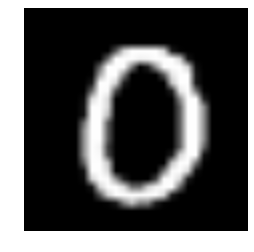

(None, array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [7]:
draw_image(X_train[10]), y_train[10]

In [8]:
X_train.shape

(55000, 28, 28, 1)

# GAN example
## Generator

In [9]:
gen_dropout = 0.4
gen_input_dim = 7
gen_depth = 128
gen_noise_dim = 50

In [10]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('sigmoid'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              319872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
__________

## Discriminator

In [11]:
disc_depth = 64
disc_dropout = 0.4

In [12]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(28, 28, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

## Discriminator model

In [13]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [14]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.00084, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [17]:
batch_size = 128
train_iters = 100

disc_losses = []
adv_losses = []

for i in range(train_iters):
    # Get random real images
    images_true = X_train[np.random.randint(0, 
                                            X_train.shape[0], 
                                            size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_fake, images_true))
    y = np.concatenate((np.zeros((batch_size, 1)), 
                        np.ones((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses.append(dics_loss) 
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses.append(adv_loss)
    
    # Print results
    print("Trained on {}th bath of {} | Disc loss: {} | Adv loss {}".format(i, train_iters, dics_loss, adv_loss))

Trained on 0th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [0.00055754272, 1.0]
Trained on 1th bath of 100 | Disc loss: [1.946584, 0.5] | Adv loss [0.50750268, 1.0]
Trained on 2th bath of 100 | Disc loss: [0.9880417, 0.5] | Adv loss [0.18030024, 1.0]
Trained on 3th bath of 100 | Disc loss: [2.5294306, 0.5] | Adv loss [0.17266101, 1.0]
Trained on 4th bath of 100 | Disc loss: [1.7647054, 0.5] | Adv loss [0.073968023, 1.0]
Trained on 5th bath of 100 | Disc loss: [1.3071071, 0.5] | Adv loss [0.041431986, 1.0]
Trained on 6th bath of 100 | Disc loss: [1.0555674, 0.5] | Adv loss [0.037950035, 1.0]
Trained on 7th bath of 100 | Disc loss: [0.86635274, 0.5] | Adv loss [0.013742178, 1.0]
Trained on 8th bath of 100 | Disc loss: [0.53876978, 0.5] | Adv loss [0.0052225417, 1.0]
Trained on 9th bath of 100 | Disc loss: [0.39674208, 0.5] | Adv loss [0.0032346086, 1.0]
Trained on 10th bath of 100 | Disc loss: [0.33873442, 0.97265625] | Adv loss [0.00019404983, 1.0]
Trained on 11th bath of 100 |

Trained on 93th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
Trained on 94th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
Trained on 95th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
Trained on 96th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
Trained on 97th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
Trained on 98th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
Trained on 99th bath of 100 | Disc loss: [7.9711924, 0.5] | Adv loss [1.1920933e-07, 1.0]
